# Investigating the ABoVE CoVAR stack with AGB predictions

In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
#from lime import lime_tabular
from pprint import pprint

import statsmodels.formula.api as smf
import statsmodels.api as sm

from lime import lime_tabular

#### Read in our data

In [4]:
datafile = '/projects/my-public-bucket/sentinel1_seasonal_comps/IS2_AGB_CoVars_training_s1.gpkg'

gdf = gpd.read_file(datafile)

In [5]:
# remove any rows with -9999
gdf = gdf[gdf['blue'] != -9999]
gdf = gdf.dropna(axis=0)

### Investigate the distribution of the independent variable (AGB)

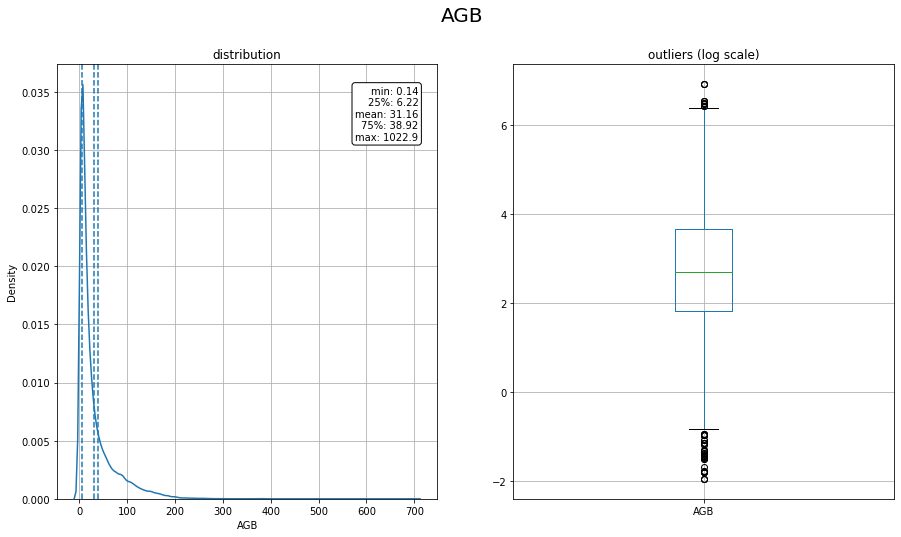

In [9]:
x = "AGB"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8),  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)
### distribution
ax[0].title.set_text('distribution')
variable = gdf[x].fillna(gdf[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
sns.kdeplot(variable, ax=ax[0])
des = gdf[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(gdf[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])
plt.show()

### Investigate the relationship between AGB and a selected dependent variable

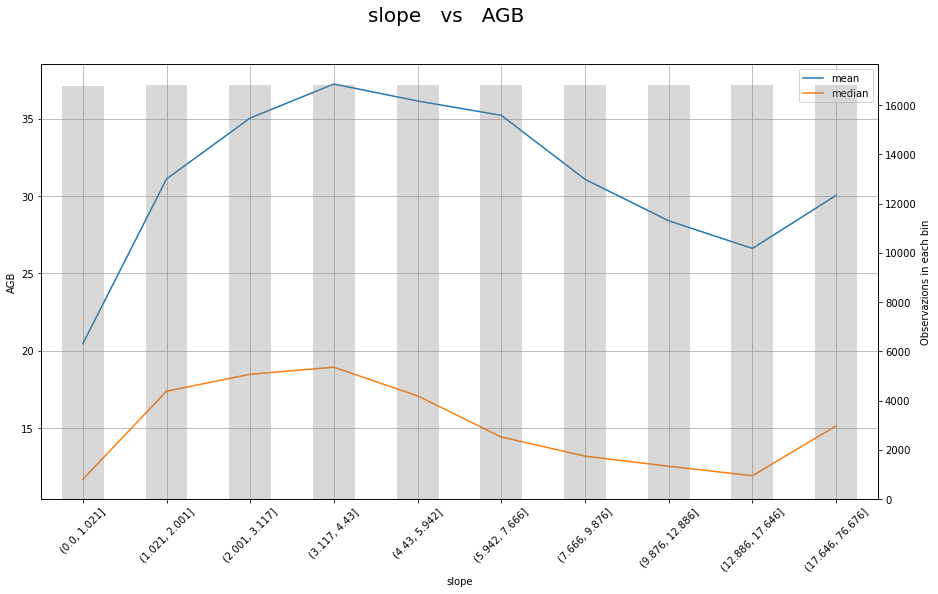

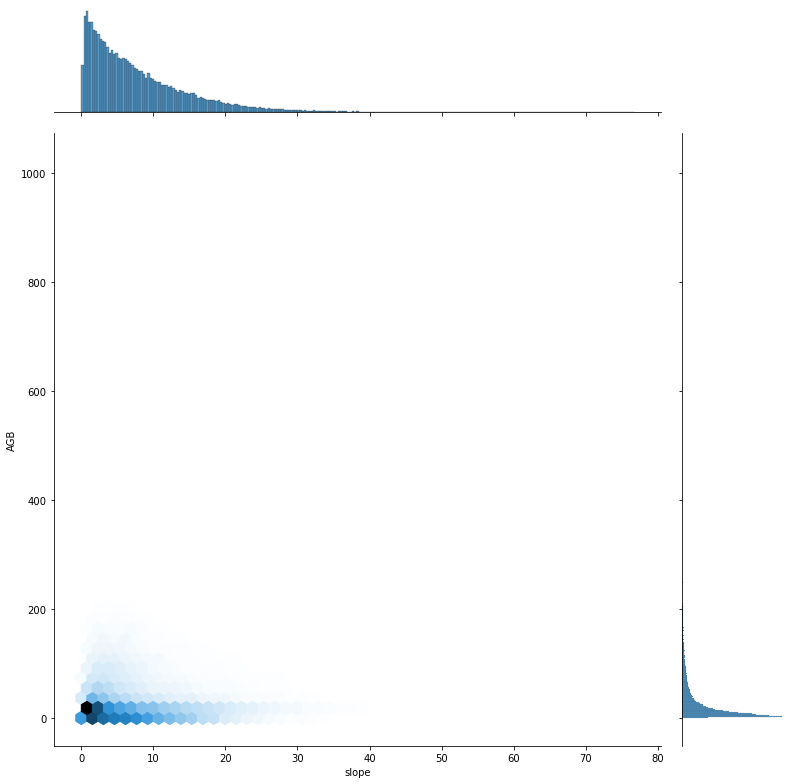

In [10]:
x, y = "slope", "AGB"
### bin plot
dtf_noNan = gdf[gdf[x].notnull()]
breaks = np.quantile(dtf_noNan[x], q=np.linspace(0, 1, 11))
groups = dtf_noNan.groupby([pd.cut(dtf_noNan[x], bins=breaks, 
           duplicates='drop')])[y].agg(['mean','median','size'])
figsize=[15,8]
fig, ax = plt.subplots(figsize=(15,8))
fig.suptitle(x+"   vs   "+y, fontsize=20)
groups[["mean", "median"]].plot(kind="line", ax=ax)
groups["size"].plot(kind="bar", ax=ax, rot=45, secondary_y=True,
                    color="grey", alpha=0.3, grid=True)
ax.set(ylabel=y)
ax.right_ax.set_ylabel("Observazions in each bin")
plt.show()
### scatter plot
sns.jointplot(x=x, y=y, data=gdf, dropna=True, kind='hex', 
              height=int((figsize[0]+figsize[1])/2) )
plt.show()

In [11]:
print(gdf.keys())

Index(['lon', 'lat', 'AGB', 'SE', 'tile_num', 'tile_num_int', 'elevation',
       'slope', 'tsri', 'tpi', 'slope_mask', 'blue', 'green', 'red', 'nir',
       'swir', 'swir2', 'ndvi', 'savi', 'msavi', 'ndmi', 'evi', 'nbr', 'nbr2',
       'tcb', 'tcg', 'tcw', 'vv_fall', 'vh_fall', 'vv_spring', 'vh_spring',
       'vv_fall_db', 'vh_fall_db', 'vv_spring_db', 'vh_spring_db', 'geometry'],
      dtype='object')


In [12]:
continuous = gdf.drop(columns=['AGB','lat','lon', 'tile_num', 'geometry', 'SE', 'tile_num_int', 'slope_mask'], axis=1)

for c in continuous:
	x, y = c, "AGB"
	dtf_noNan = gdf[gdf[x].notnull()]
	coeff, p = scipy.stats.pearsonr(dtf_noNan[x], dtf_noNan[y])
	coeff, p = round(coeff, 3), round(p, 3)
	conclusion = "Significant" if p < 0.05 else "Non-Significant"
	print(c,":Pearson Correlation:", coeff, conclusion, "(p-value: "+str(p)+")")

elevation :Pearson Correlation: -0.244 Significant (p-value: 0.0)
slope :Pearson Correlation: -0.011 Significant (p-value: 0.0)
tsri :Pearson Correlation: -0.006 Significant (p-value: 0.013)
tpi :Pearson Correlation: 0.072 Significant (p-value: 0.0)
blue :Pearson Correlation: -0.251 Significant (p-value: 0.0)
green :Pearson Correlation: -0.391 Significant (p-value: 0.0)
red :Pearson Correlation: -0.371 Significant (p-value: 0.0)
nir :Pearson Correlation: -0.149 Significant (p-value: 0.0)
swir :Pearson Correlation: -0.397 Significant (p-value: 0.0)
swir2 :Pearson Correlation: -0.366 Significant (p-value: 0.0)
ndvi :Pearson Correlation: 0.175 Significant (p-value: 0.0)
savi :Pearson Correlation: -0.019 Significant (p-value: 0.0)
msavi :Pearson Correlation: -0.036 Significant (p-value: 0.0)
ndmi :Pearson Correlation: 0.332 Significant (p-value: 0.0)
evi :Pearson Correlation: -0.397 Significant (p-value: 0.0)
nbr :Pearson Correlation: -0.036 Significant (p-value: 0.0)
nbr2 :Pearson Correla

##   Preprocessing
- each observation must be represented by a single row, 
- The dataset must be partitioned into at least two sets: testing and training
- Categorical data must be encoded, which means converting labels into integers because machine learning expects numbers, not strings.
- It’s good practice to scale the data, it helps to normalize the data within a particular range and speed up the calculations in an algorithm.


#### First, drop columns not needed in modeling


In [13]:
dtf = gdf.drop(columns=['lat','lon', 'tile_num', 'geometry', 'SE', 'tile_num_int', 'slope_mask', 'vv_fall', 'vh_fall', 'vv_spring', 'vh_spring'], axis=1)


In [14]:
## split data
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)

## print info
print("X_train shape:", dtf_train.drop("AGB",axis=1).shape, "| X_test shape:", dtf_test.drop("AGB",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["AGB"]),2), "| y_test mean:", round(np.mean(dtf_test["AGB"]),2))
print(dtf_train.shape[1], "features:", dtf_train.drop("AGB",axis=1).columns.to_list())

X_train shape: (117687, 24) | X_test shape: (50438, 24)
y_train mean: 31.29 | y_test mean: 30.84
25 features: ['elevation', 'slope', 'tsri', 'tpi', 'blue', 'green', 'red', 'nir', 'swir', 'swir2', 'ndvi', 'savi', 'msavi', 'ndmi', 'evi', 'nbr', 'nbr2', 'tcb', 'tcg', 'tcw', 'vv_fall_db', 'vh_fall_db', 'vv_spring_db', 'vh_spring_db']


### For regression problems, it is often desirable to transform both the input and the target variables. This normalizes the different variables to the same scale (0 - 1) rather than the widely varying scales they have. Their distributions remian the same, but they all occur within the same range. I shall use the RobustScaler which transforms the feature by subtracting the median and then dividing by the interquartile range (75% value — 25% value). The advantage of this scaler is that it’s less affected by outliers.

In [15]:
# Train
## scale X
scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
X_train = scalerX.fit_transform(dtf_train.drop("AGB", axis=1))
X_test = scalerX.fit_transform(dtf_test.drop("AGB", axis=1))

dtf_scaled_train= pd.DataFrame(X_train, columns=dtf_train.drop("AGB", axis=1).columns, index=dtf_train.index)
dtf_scaled_test= pd.DataFrame(X_test, columns=dtf_test.drop("AGB", axis=1).columns, index=dtf_test.index)


dtf_scaled_train["y_train_scaled"] = scalerY.fit_transform(dtf_train["AGB"].values.reshape(-1,1))
dtf_scaled_test["y_test_scaled"] = scalerY.fit_transform(dtf_test["AGB"].values.reshape(-1,1))


## Feature Selection

### I already did a first “manual” feature selection during data analysis by excluding irrelevant columns. Now it’s going to be a bit different because we have to deal with the multicollinearity problem, which refers to a situation in which two or more explanatory variables in a multiple regression model are highly linearly related.Let’s compute the correlation matrix to see it:

Text(0.5, 1.0, 'pearson correlation')

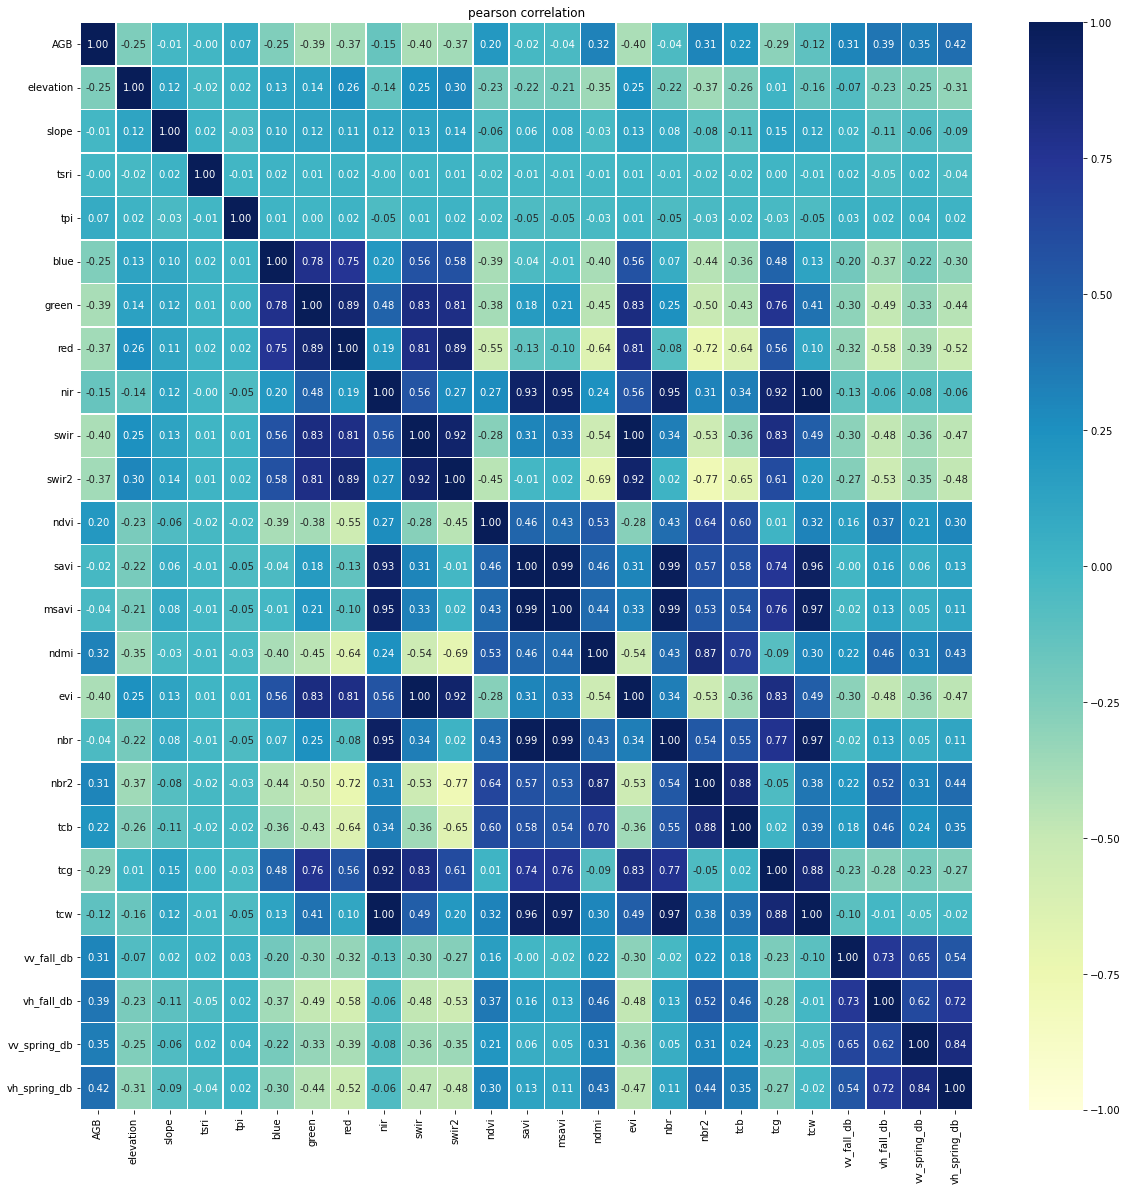

In [16]:
plt.figure(figsize=(20,20))
corr_matrix = dtf_train.corr(method="pearson")
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")

# ML FEATURE SELECTION
### Alternatively, you can use ensemble methods to get feature importance. Ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone. I will give an example using a random forest model.

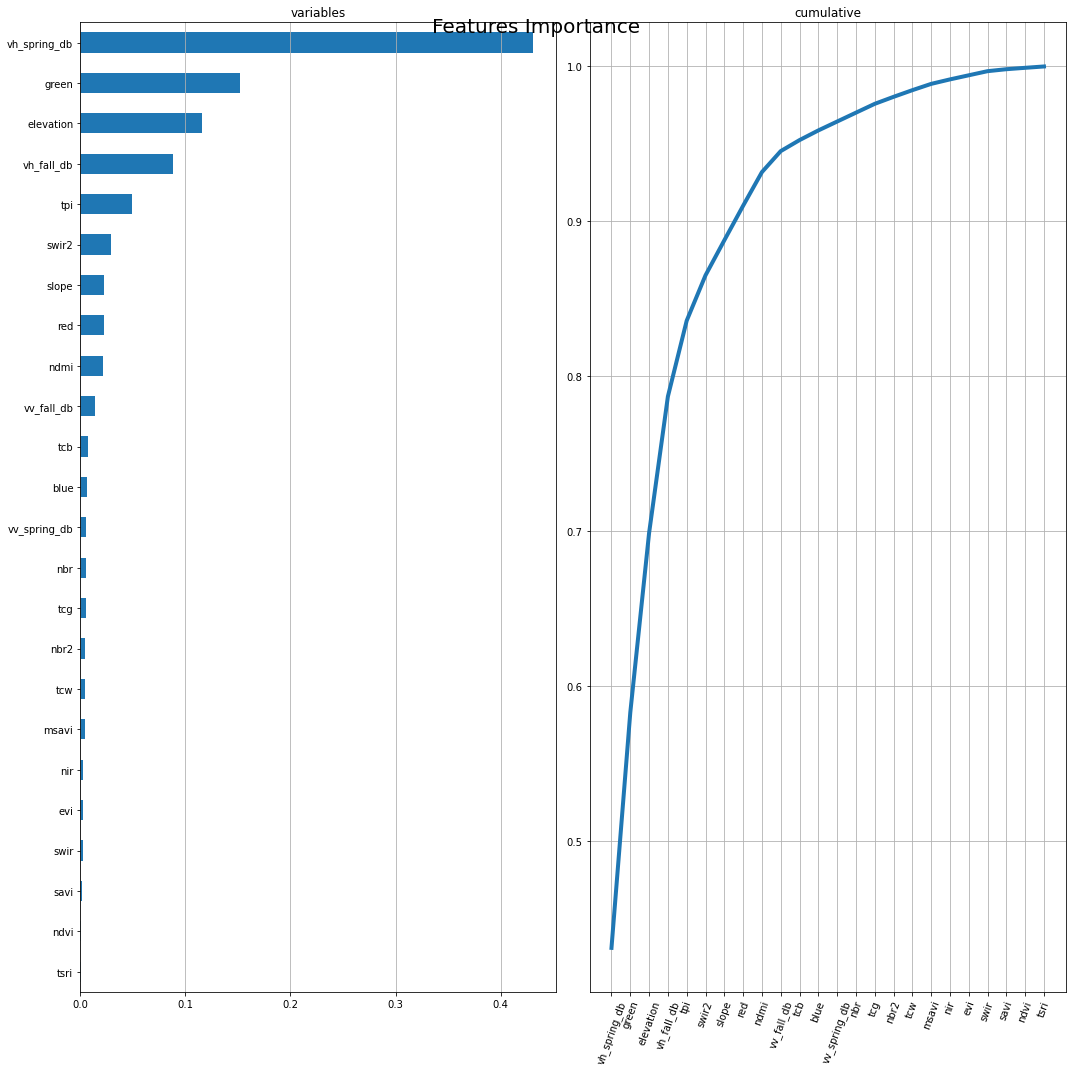

In [18]:
X = dtf_scaled_train.drop("y_train_scaled", axis=1).values
y = dtf_scaled_train["y_train_scaled"].values
feature_names = dtf_scaled_train.drop("y_train_scaled", axis=1).columns.tolist()
## call model
model = ensemble.GradientBoostingRegressor()
## Importance
model.fit(X,y)
importances = model.feature_importances_
## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, "VARIABLE":feature_names}).sort_values("IMPORTANCE", ascending=False)
dtf_importances['cumsum'] =  dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,15), sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), 
xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.tight_layout()
plt.savefig("/projects/my-public-bucket/sentinel1_seasonal_comps/IS2_AGB_CoVars_training_s1_variable importance.png", format="PNG")
plt.show()

#### Here we can see how the variables are ranked in terms of importance in our model. we can see the vh_spring_sdB explains >40% of our model already, with the remaining variables making up roughly an equitable amount all combined.

#### So now let's build our model using only the most important variables. For this we will select the top 8 and create our training and testing datasets.

In [16]:
# Get test and train data from scaled test and train
X_names = ['vh_spring_db', 'green', 'elevation', "vh_fall_db", 'tpi', 'swir2', 'red', 'slope']
X_train = dtf_scaled_train[X_names].values
y_train = dtf_scaled_train["y_train_scaled"].values
X_test = dtf_scaled_test[X_names].values
y_test = dtf_scaled_test["y_test_scaled"].values

## Model Design
### Finally, it’s time to build the machine learning model. I will first run a simple linear regression and use it as a baseline for a more complex model, like the random forest model. The first metric I normally use is the R squared, which indicates the proportion of the variance in the dependent variable that is predictable from the independent variable.
### I will compare the linear regression R squared with the random forest one using k-fold cross-validation, a procedure that consists in splitting the data k times into train and validation sets and for each split, the model is trained and tested. It’s used to check how well the model is able to get trained by some data and predict unseen data.
### I will visualize the results of the validation by plotting predicted values against the actual Y. Ideally, points should be all close to a diagonal line where predicted = actual.

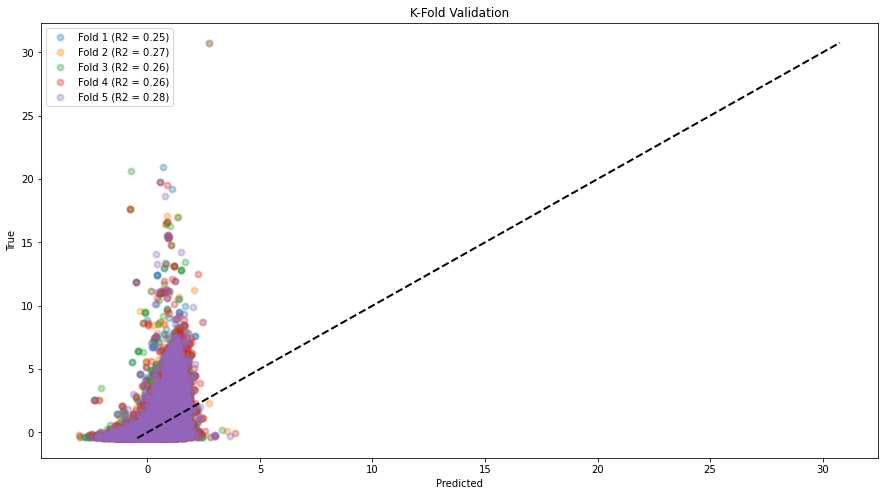

In [17]:
## call model
model = linear_model.LinearRegression()
## K fold validation
scores = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure(figsize=(15,8))
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train],
                 y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1


plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()

#### This looks like it could be crap but let's runit for a baseline prior to ML

In [18]:
## train
model.fit(X_train, y_train)
## test
predicted = model.predict(X_test)

In [19]:
# unscale the units
predicted = scalerY.inverse_transform( predicted.reshape(-1,1) ).reshape(-1)
observed = scalerY.inverse_transform( y_test.reshape(-1,1) ).reshape(-1)

In [20]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(observed, predicted), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((observed-predicted)/predicted)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(observed, predicted)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(observed, predicted))))
## residuals
residuals = observed - predicted
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = observed[max_idx], predicted[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.26
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 1.15
Mean Absolute Error (Σ|y-pred|/n): 23
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 35
Max Error: 918


#### approx 120% error. lol

# RF Regressor

### ML algorithms have many knobs and dials. These are known as hyperparamaters. To look at the available hyperparameters, we can create a random forest and examine the default values.

In [27]:
rf = RandomForestRegressor(random_state = 42)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


### n_estimators = number of trees in the foreset
### max_features = max number of features considered for splitting a node
### max_depth = max number of levels in each decision tree
### min_samples_split = min number of data points placed in a node before the node is split
### min_samples_leaf = min number of data points allowed in a leaf node
### bootstrap = method for sampling data points (with or without replacement)

### Below is a function that will run either a random or grid search for hyperparameter tuning. This process can take a very long time and can be compute intensive. 

In [28]:
def tune_regr_model(X_train, y_train, model_base=None, param_dic=None, scoring="r2", searchtype="RandomSearch", n_iter=1000, cv=10, figsize=(10,5)):
    model_base = ensemble.GradientBoostingRegressor() if model_base is None else model_base
    param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,250,500,750,1000,1250,1500,1750], 'max_depth':[2,3,4,5,6,7]} if param_dic is None else param_dic                        

    ## Search
    print("---", searchtype, "---")
    if searchtype == "RandomSearch":
        random_search = model_selection.RandomizedSearchCV(model_base, param_distributions=param_dic, n_iter=n_iter, scoring=scoring).fit(X_train, y_train)
        print("Best Model parameters:", random_search.best_params_)
        print("Best Model "+scoring+":", round(random_search.best_score_, 2))
        model = random_search.best_estimator_
    
    elif searchtype == "GridSearch":
        grid_search = model_selection.GridSearchCV(model_base, param_dic, scoring=scoring).fit(X_train, y_train)
        print("Best Model parameters:", grid_search.best_params_)
        print("Best Model mean "+scoring+":", round(grid_search.best_score_, 2))
        model = grid_search.best_estimator_
    
    ## K fold validation
    print("")
    print("--- Kfold Validation ---")
    Kfold_base = model_selection.cross_validate(estimator=model_base, X=X_train, y=y_train, cv=cv, scoring=scoring)
    Kfold_model = model_selection.cross_validate(estimator=model, X=X_train, y=y_train, cv=cv, scoring=scoring)
    print(scoring, "mean - base model:", round(Kfold_base["test_score"].mean(),2), " --> best model:", round(Kfold_model["test_score"].mean()))
    
    scores = []
    cv = model_selection.KFold(n_splits=cv, shuffle=True)
    fig = plt.figure(figsize=figsize)
    i = 1
    for train, test in cv.split(X_train, y_train):
        prediction = model.fit(X_train[train], y_train[train]).predict(X_train[test])
        true = y_train[test]
        score = metrics.r2_score(true, prediction)
        scores.append(score)
        plt.scatter(prediction, true, lw=2, alpha=0.3, label='Fold %d (R2 = %0.2f)' % (i,score))
        i = i+1
    plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], linestyle='--', lw=2, color='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('K-Fold Validation')
    plt.legend()
    plt.show()
    
    return model

--- RandomSearch ---
Best Model parameters: {'n_estimators': 500, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 3, 'max_depth': 3, 'bootstrap': True}
Best Model r2: 0.36

--- Kfold Validation ---
r2 mean - base model: 0.75  --> best model: 0


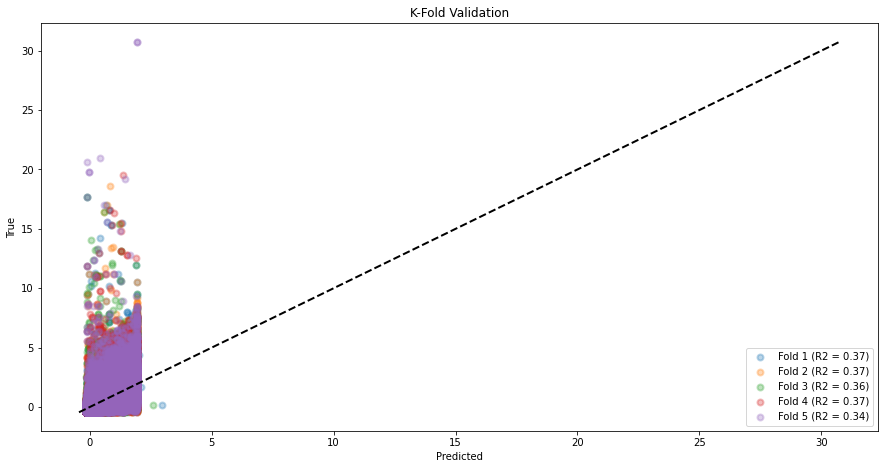

RandomForestRegressor(max_depth=3, max_features=3, min_samples_split=4,
                      n_estimators=500)


In [30]:
#Tune regressor

#pick model
model = ensemble.RandomForestRegressor()

param_dic = {#'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],      #weighting factor for the corrections by new trees when added to the model
             'n_estimators':[100,250,500],  #number of trees added to the model
             'max_depth':[2,3],                             #maximum depth of the tree
             'min_samples_split':[2,4,6],         #sets the minimum number of samples to split
             'min_samples_leaf':[1,3,5],                        #the minimum number of samples to form a leaf
             'max_features':[2,3],
             'bootstrap': [True]}                     #square root of features is usually a good starting point
             #'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}
# run tune
model = tune_regr_model(X_train, y_train, model, param_dic, scoring="r2", searchtype="RandomSearch", n_iter=5, cv=5, figsize=(15,7.5))

print(model)

In [34]:
model = RandomForestRegressor(max_depth=3, max_features=3, min_samples_split=4,
                      n_estimators=500)

# Best parameters
print('best model =', model)

best model = RandomForestRegressor(max_depth=3, max_features=3, min_samples_split=4,
                      n_estimators=500)


In [36]:
def evaluate(model, X_train, y_train):
    model.fit(X_train, y_train)
    predictions = model.predict(X_train)
    errors = abs(predictions - y_train)
    mape = 100 * np.mean(errors / y_train)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [37]:
grid_accuracy = evaluate(model, X_test, y_test)

Model Performance
Average Error: 0.6036 degrees.
Accuracy = 156.59%.


# Run the RF Regressor

In [38]:
## train
model.fit(X_train, y_train)
## test
predicted_rf = model.predict(X_test)

### and again, unscale our values to a more understandable range and print out a predicted and observed value for comparisson.

In [39]:
predicted_rf = scalerY.inverse_transform(predicted_rf.reshape(-1,1) ).reshape(-1)
observed_rf = scalerY.inverse_transform(y_test.reshape(-1,1) ).reshape(-1)
print(predicted[0],observed_rf[0])

37.35800246227476 32.1739937928778


### And again, let's look at our stats. We should be able to see an improvement in r2 and % error if our model is well tuned. We can also visualize our k-folds and look at their distributions.

R2 (explained variance): 0.35
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.67
Mean Absolute Error (Σ|y-pred|/n): 20
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 33
Max Error: 922


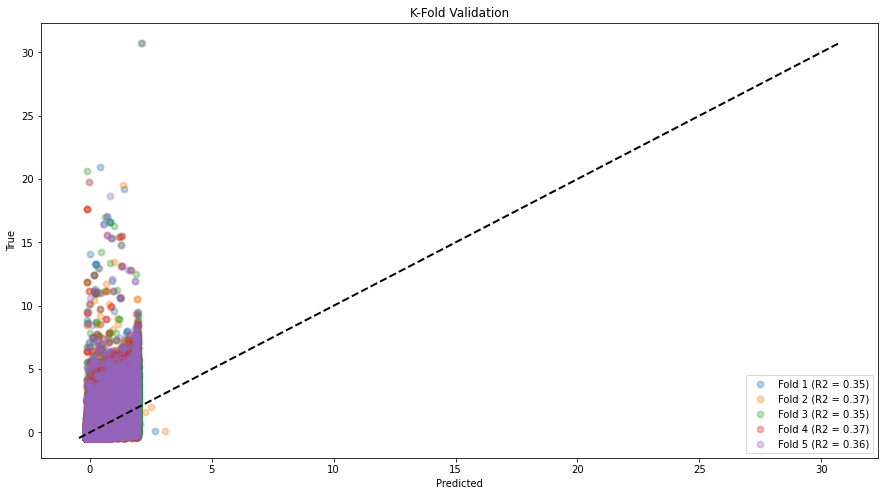

In [40]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(observed_rf, predicted_rf), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((observed_rf-predicted_rf)/predicted_rf)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(observed_rf, predicted_rf)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(observed_rf, predicted_rf))))
## residuals
residuals = observed_rf - predicted_rf
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], predicted_rf[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

## call model

## K fold validation
scores = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure(figsize=(15,8))
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train],
                 y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1


plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()

### And we can plot our model and our residuals so that we can see how well our model performed overall

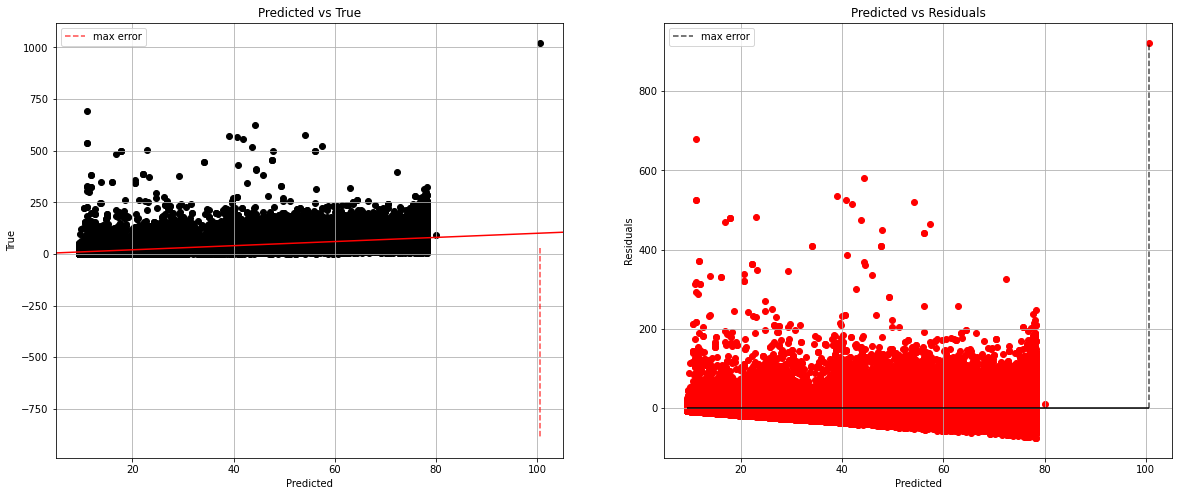

In [45]:
## Plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
from statsmodels.graphics.api import abline_plot
ax[0].scatter(predicted_rf, observed_rf, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color='red', linestyle='--', alpha=0.7, label="max error")
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
## Plot predicted vs residuals
ax[1].scatter(predicted_rf, residuals, color="red")
ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(predicted_rf), xmax=np.max(predicted_rf))
ax[1].legend()
plt.show()

### We can also plot our distribution of the residuals so we can visualize what the distribution of our error was.

<Figure size 1440x576 with 0 Axes>

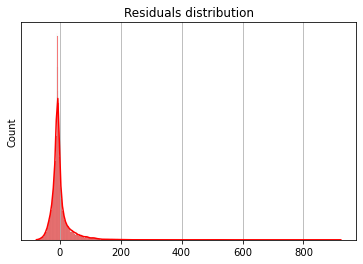

In [46]:
residuals = observed_rf - predicted_rf
plt.figure(figsize=(20,8))
fig, ax = plt.subplots()
sns.histplot(residuals, color="red", kde=True, ax=ax)
ax.grid(True)
ax.set(yticks=[], yticklabels=[], title="Residuals distribution")
plt.show()

# Explainability
### You analyzed and understood the data, you trained a model and tested it, you’re even satisfied with the performance. You can go the extra mile and show that your machine learning model is not a black box.
### The Lime package can help us to build an explainer. To give an illustration I will take a random observation from the test set and see what the model predicts:

In [47]:
print("True:", "{:,.0f}".format(observed_rf[1]), "--> Pred:", "{:,.0f}".format(predicted_rf[1]))

True: 129 --> Pred: 65


### The model predicted a AGB:

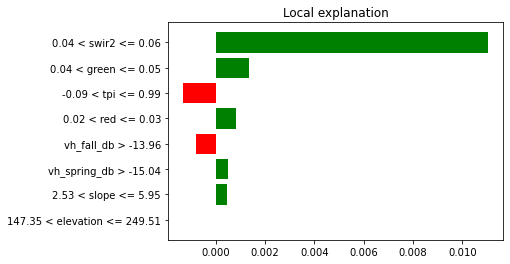

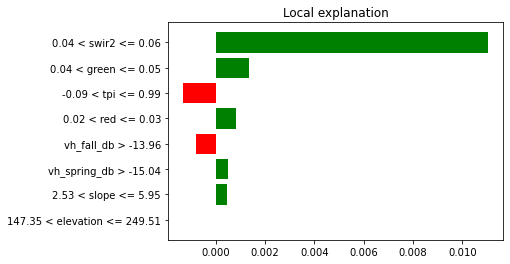

In [52]:
X_names = ['vh_spring_db', 'green', 'elevation', "vh_fall_db", 'tpi', 'swir2', 'red', 'slope']
explainer = lime_tabular.LimeTabularExplainer(training_data=dtf_train[X_names].values, feature_names=X_names, class_names="Y", mode="regression")
explained = explainer.explain_instance((dtf_test[X_names].values)[10], model.predict, num_features=10)
explained.as_pyplot_figure()